# Importanto os Pacotes Necessários

In [21]:
import ipsimpy as ip
import matplotlib.pyplot as plt
import numpy as np

# Solução do Problema Direto
A solução do problema direto será definida da seguinte maneira:

$f(t)=ae^{-bt}$

sendo os valores de $a$ e $b$ os parâmetros de que queremos estimar.

Uma vez conhecida a expressão da solução e os parâmetros de interesse, vamos assumir o vetor de parâmetros como sendo $Z = (a,b)$. Note que ao criar a função que representa a soluçao do nosso problema direto um de seus argumentos precisa ser o vetor de parâmetros.

In [22]:
def Solucao(Z,t):
    a=Z[0]
    b=Z[1]
    return a*np.exp(-b*t)

### Definiçao dos Parâmetros Exatos

Em um problema real não conhecemos o valor dos parâmetros exatos mas, nesse tutorial, vamos assumir esses valores como sendo $a=1.0$ e $b=2.5$

In [23]:
Z_exato=np.array([1.0,2.5])

### Definição dos Dados Experimentais Sintéticos

Os parâmetros são recuperados a partir de um conjunto de dados experimentais.

Em nosso tutorial vamos considerar um conjunto de dados experimentais gerados artificialmente com 25 medições no intervalo $0 \leq t \leq 1$, note que no caso de um problema associado a uma EDP também seria necessário escolher uma posição.

In [24]:
t0 = 0 # tempo inicial
tf = 1 # tempo final

In [25]:
t_exp=np.linspace(0.1,tf,25) # tempo experimentais
t_exp

array([0.1   , 0.1375, 0.175 , 0.2125, 0.25  , 0.2875, 0.325 , 0.3625,
       0.4   , 0.4375, 0.475 , 0.5125, 0.55  , 0.5875, 0.625 , 0.6625,
       0.7   , 0.7375, 0.775 , 0.8125, 0.85  , 0.8875, 0.925 , 0.9625,
       1.    ])

Com os tempos experimentais, somos capazes de gerar agora o conjunto de dados exatos

In [26]:
Dados_Exatos=Solucao(Z_exato,t_exp) # dados exatos 

Sabemos que todo experimento está associado a erros experimentais, vamos simular esse erro adocionando um ruído gaussinao com média zero e desvio padrão igual a $0.01$. 

In [27]:
sigma = 0.01

In [28]:
Dados_Exp=Dados_Exatos + np.random.normal(0,sigma,len(t_exp))

Vejamos graficamente o conjunto gerado

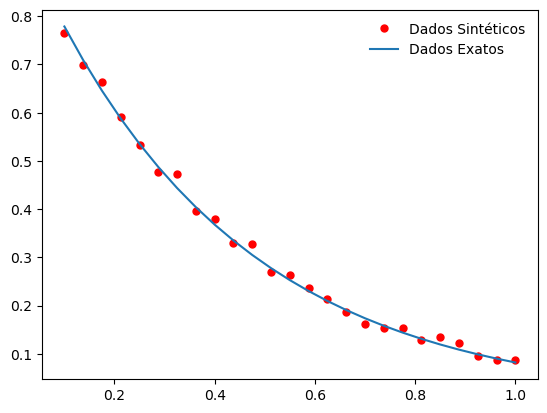

In [29]:
plt.plot(t_exp,Dados_Exp,".r",ms=10, label='Dados Sintéticos')
plt.plot(t_exp,Dados_Exatos, label='Dados Exatos')
plt.legend(frameon=False);

# Solução do Problema Inverso
Agora utilizaremos o pacote ipsimpy que foi carregado como ip. Será necessário informar ao Pacote algumas informações preliminares que correspondem aos dados e os tempos experimentais, além da função que representa a solução do problema direto.

In [30]:
def SPD(Z):
    a=Z[0]
    b=Z[1]
    return a*np.exp(-b*t_exp)

> note que utilizamos diretamente os tempos experimentais `t_exp`

Vamos definir nossa função objetivo como sendo a de mínimos quadrados

In [31]:
def FO(Z):
    Dados_Calc=SPD(Z)
    return np.dot(Dados_Calc - Dados_Exp, Dados_Calc - Dados_Exp)

Vamos testar nossa função objetivo considerando o vetor de parâmetros $Z=(1,1)$

In [33]:
FO(np.array([1.,1.]))

2.037507645143717

Nesse momento o pacote precisa saber:
* Os dados experimentais
* Os tempos experimentais
* A função objetivos
* A solução do problema direto 
* O número de parâmetros

In [32]:
ip.Definicoes_Preliminares.Set_Dados_Exp(Dados_Exp)
ip.Definicoes_Preliminares.Set_Tempos_Exp(t_exp)
ip.Definicoes_Preliminares.Set_FuncaoObjetivo(FO)
ip.Definicoes_Preliminares.Set_Solucao_PD(SPD)
ip.Definicoes_Preliminares.Set_Numero_Parametros(Z_exato.size)

Note que ao passar a função objetivo o ipsimpy passa a utilizá-la da seguinte maneira:

In [34]:
ip.Definicoes_Preliminares.FO(np.array([1.,1.]))

2.037507645143717

> A definição da função objetivo será de responsabilidade do usuário. Caso exista algum parâmetro de regularização este já deve ser inserido na formulação da FO.

## Análise de Sensibilidade

In [10]:
t_sensibilidade=np.linspace(0.1,tf,100)

In [11]:
def SPD_Sensibilidade(Z):
    return Solucao(Z,t_sensibilidade)

In [12]:
Delta_h=np.array([10**-3,10**-3])
Sensibilidade=ip.Analise_Sensibilidade(SPD_Sensibilidade,Z_exato,t_sensibilidade,Delta_h)

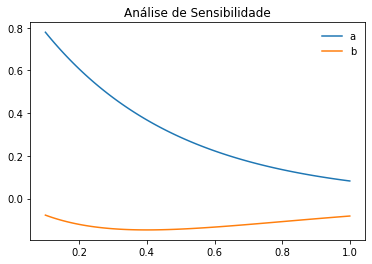

In [13]:
plt.figure()
plt.title("Análise de Sensibilidade")
plt.plot(t_sensibilidade,Sensibilidade.Parametro[0],label='a')
plt.plot(t_sensibilidade,Sensibilidade.Parametro[1],label='b')
plt.legend(frameon=False);

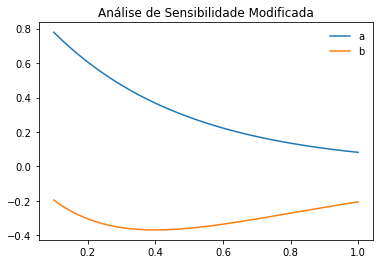

In [14]:
plt.figure()
plt.title("Análise de Sensibilidade Modificada")
plt.plot(t_sensibilidade,Z_exato[0]*Sensibilidade.Parametro[0],label='a')
plt.plot(t_sensibilidade,Z_exato[1]*Sensibilidade.Parametro[1],label='b')
plt.legend(frameon=False);

#### Solução Problema Inverso Levemberg-Marquardt
Para cada método de otimização é possível definir valores para algumas opções específicas opcionais. Essas opções são formuladas como um dicionário em python, por exemplo, podemos mudar o número de iterações do LM. Lembro que, por padrão, essas opções já possuem um valor defaut. Vejamos seus valores

In [15]:
ip.Levemberg_Marquardt.Defaut

{'Omega': 10, 'MaxIter': 10, 'Tolerancia': 1e-05, 'VerOpcoes': False}

**Obs:** As strings com os nomes das opçoes devem ser escritas do mesmo modo que estão definidas no defaut, caso contrário será acusado um erro ao se executar o método de otimização.

In [16]:
Z0=np.array([2.0,5.0])
Delta_h=np.array([10**-3,10**-3])
opcoesLM={"Omega":10,"MaxIter":10,"Tolerancia":10**-10,"VerOpcoes":True}
ResultadosLM=ip.Levemberg_Marquardt(FO,Z0,Delta_h,opcoesLM)

Iteração: 10
 
OPÇÕES LEVEMBERG MARQUARDT
omega inicial=1e+01
omega final=1e-07
Pk= [0.99299757 2.48506476]
Tolerância=1e-10
Valor na FO=2.57005e-03
Numero Máximo de Iterações= 10
Numero de Iterações Utilizado= 10
Passo h=[0.001 0.001]
 


A variável ResultadosLM guarda além dos parâmetros estimados, seu valor na FO, convergência e tempo de execução do processo iterativo, veja

In [17]:
ResultadosLM.Parametros_Estimados

array([0.99299757, 2.48506476])

In [18]:
ResultadosLM.Valor_FO

0.002570053393949831

In [19]:
ResultadosLM.Convergencia

array([0.5044683 , 0.39300259, 0.21804787, 0.00888775, 0.00257075,
       0.00257005, 0.00257005, 0.00257005, 0.00257005, 0.00257005])

In [20]:
ResultadosLM.Custo_Computacional

0.034982919692993164

**Obs:** Todos os outros métodos de minimização possuem essas mesmas características

Vejamos a comparação dos gráficos entre as soluções com os parâmetros exatos e estimados juntamente com os dados experimentais 

Text(0, 0.5, 'Solucao')

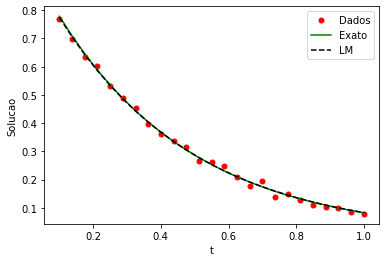

In [21]:
plt.plot(t_exp,Dados_Exp,".r",ms=10)
plt.plot(t_exp,ip.Definicoes_Preliminares.Solucao_PD(Z_exato),"g")
plt.plot(t_exp,ip.Definicoes_Preliminares.Solucao_PD(ResultadosLM.Parametros_Estimados),"--k")
plt.gca().legend(('Dados','Exato','LM'))
plt.xlabel('t')
plt.ylabel('Solucao')

#### Solução Problema Inverso Evolução Diferencial
Já para o Evolução Diferencial é necessário definir outros parâmetros específicos do método. Vejamos as opções defaut

In [22]:
ip.Evolucao_Diferencial.Defaut

{'F': 0.8, 'CR': 0.5, 'Gmax': 100, 'Tolerancia': 1e-05, 'VerOpcoes': False}

Vamos então a solução do Problema Inverso

In [23]:
limites=[(0.0,10.0),(0.0,10.0)]
Tam_Populacao=20
opcoesDE={"F":0.75, "CR":0.9, "Gmax":50, "Tolerancia":10**-10,"VerOpcoes":True}
ResultadosDE=ip.Evolucao_Diferencial(FO,Tam_Populacao,limites,opcoesDE)

Geração: 50

OPÇÕES EVOLUÇÃO DIFERENCIAL
Tamanho População=20
Numero Máximo de Gerações=50
Numero de Gerações Utilizado=50
Taxa de Mutacao=0.75
Taxa de CrossOver=0.9
Melhor Membro da População=[0.99299029 2.48501341]
Valor na FO=2.570054e-03
Tolerância=1e-10



Vamos mais uma vez os gráficos das curvas de solução usando os parâmetros exatos e os estimados usando o Pacote Problemas Inversos

Text(0, 0.5, 'Solucao')

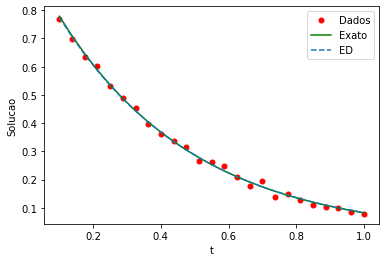

In [24]:
plt.plot(t_exp,Dados_Exp,".r",ms=10)
plt.plot(t_exp,ip.Definicoes_Preliminares.Solucao_PD(Z_exato),"g")
plt.plot(t_exp,ip.Definicoes_Preliminares.Solucao_PD(ResultadosDE.Parametros_Estimados),"--")
plt.gca().legend(('Dados','Exato','ED'))
plt.xlabel('t')
plt.ylabel('Solucao')

#### Solução Problema Inverso Evolução Diferencial com Controle Populacional
Vejamos as opções defaut

In [25]:
ip.Evolucao_Diferencial_Controle_Pop.Defaut

{'F': 0.8, 'CR': 0.5, 'Gmax': 100, 'Tolerancia': 1e-05, 'VerOpcoes': False}

Vamos então a solução do Problema Inverso

In [26]:
limites=[(0.0,10.0),(0.0,10.0)]
Nmin=5
Nmax=20
opcoesIDE={"F":0.75, "CR":0.9, "Gmax":50, "Tolerancia":10**-10,"VerOpcoes":True}
ResultadosIDE=ip.Evolucao_Diferencial_Controle_Pop(FO,Nmin,Nmax,limites,opcoesIDE)

Geração: 50
OPÇÕES EVOLUÇÃO DIFERENCIAL
Tamanho População=5
Numero Máximo de Gerações=50
Numero de Gerações Utilizado=50
Taxa de Mutacao=0.75
Taxa de CrossOver=0.9
Melhor Membro da População=[0.9929006 2.4847825]
Valor na FO=2.570064e-03
Tolerância=1e-10



Vamos mais uma vez os gráficos das curvas de solução usando os parâmetros exatos e os estimados usando o Pacote Problemas Inversos

Text(0, 0.5, 'Solucao')

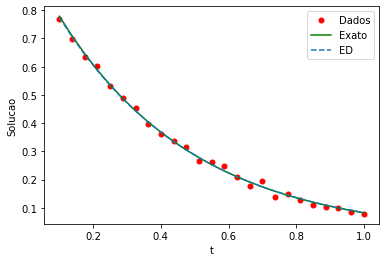

In [27]:
plt.plot(t_exp,Dados_Exp,".r",ms=10)
plt.plot(t_exp,ip.Definicoes_Preliminares.Solucao_PD(Z_exato),"g")
plt.plot(t_exp,ip.Definicoes_Preliminares.Solucao_PD(ResultadosDE.Parametros_Estimados),"--")
plt.gca().legend(('Dados','Exato','ED'))
plt.xlabel('t')
plt.ylabel('Solucao')

Text(0, 0.5, 'Tamanho População')

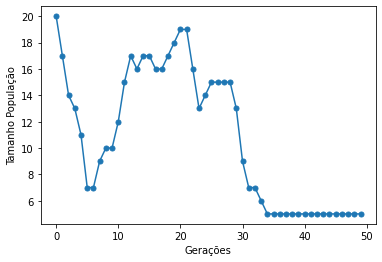

In [28]:
iteracoes=np.arange(opcoesIDE["Gmax"])

plt.plot(iteracoes,ResultadosIDE.N_Populacao,".-",ms=10);
plt.xlabel('Gerações')
plt.ylabel('Tamanho População')

#### Solução Problema Inverso PSO

Por fim temos a solução empregando o Particle Swarm Optimization, sendo as opções defaut definidas como

In [29]:
ip.PSO.Defaut

{'w': 0.5,
 'c1': 1.0,
 'c2': 2.0,
 'MaxIter': 100,
 'Tolerancia': 1e-05,
 'VerOpcoes': False}

Aplicando agora o PSO ao problema inverso

In [30]:
limites=([0.0,10.0],[0.0,10.0])
N_particulas=20
opcoesPSO={"w":1.0, "c1":2.05, "c2":2.05, "MaxIter":50, "Tolerancia":10**-10,"VerOpcoes":True}
ResultadosPSO=ip.PSO(FO,N_particulas,limites,opcoesPSO)

Geração: 50
OPÇÕES ENXAME DE PARTÍCULAS (PSO)
Numero de Particulas=20
Numero Máximo de Iterações=50
Numero de Iterações Utilizado=50
w=1.0
c1=2.05
c2=2.05
Tolerancia=1e-10
Melhor Elemento do Enxame= [0.99170375 2.48263104]
Valor na FO=2.572136e-03



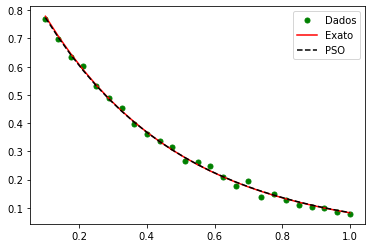

In [31]:
plt.plot(t_exp,Dados_Exp,".g",ms=10)
plt.plot(t_exp,ip.Definicoes_Preliminares.Solucao_PD(Z_exato),"r")
plt.plot(t_exp,ip.Definicoes_Preliminares.Solucao_PD(ResultadosPSO.Parametros_Estimados),"--k")
plt.gca().legend(('Dados','Exato','PSO'))

### Solução Problema Inverso MCMC

Por fim temos a solução empregando o MCMC, sendo as opções defaut definidas como

In [34]:
ip.Definicoes_Preliminares.Set_Matriz_Covariancia(Dados_Exp,sigma)
Passo=np.array([10**-4,10**-4])

In [35]:
Z0=np.array([2.0,4.0])

In [36]:
print(Z0[0]*Passo[0])
print(Z0[1]*Passo[1])

0.0002
0.0004


In [38]:
Nmcmc=10000
Nburn=5000

ResultadosMCMC=ip.MCMC_Sem_Priori(SPD,Z0,Nmcmc,Nburn,Passo)

Estado: 10000


In [39]:
print('Taxa de Aceitação:',ResultadosMCMC.Taxa_Aceitação*100,'%')

Taxa de Aceitação: 49.04 %


In [40]:
ResultadosMCMC.Media_Parametro

array([0.99454963, 2.49194612])

In [41]:
print('PARAMETROS ESTIMADOS')
print('a:',ResultadosMCMC.Media_Parametro[0],'com desvio padrão:',ResultadosMCMC.Desvio_Parametro[0])
print('b:',ResultadosMCMC.Media_Parametro[1],'com desvio padrão:',ResultadosMCMC.Desvio_Parametro[1])

PARAMETROS ESTIMADOS
a: 0.9945496291038708 com desvio padrão: 0.009155715243439673
b: 2.491946122493987 com desvio padrão: 0.029344547148424976


In [42]:
print('Intervalos de Confiança')
print('a:',ResultadosMCMC.Intervalo_Confianca[0])
print('b:',ResultadosMCMC.Intervalo_Confianca[1])

Intervalos de Confiança
a: [0.96121868 1.02236602]
b: [2.38641564 2.5694458 ]


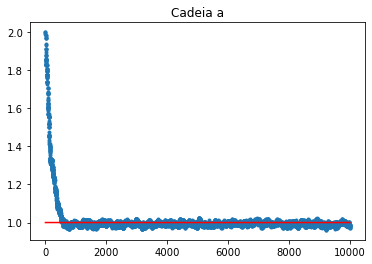

In [45]:
valor_exato0=np.zeros(Nmcmc);
for i in range(Nmcmc):
    valor_exato0[i]=Z_exato[0]

plt.title('Cadeia a')
plt.plot(ResultadosMCMC.Cadeias[:,0],".");
plt.plot(valor_exato0,'r');

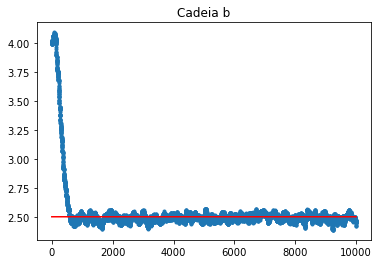

In [46]:
valor_exato1=np.zeros(Nmcmc);
for i in range(Nmcmc):
    valor_exato1[i]=Z_exato[1]

plt.title('Cadeia b')
plt.plot(ResultadosMCMC.Cadeias[:,1],".");
plt.plot(valor_exato1,'r');

# Comparação dos Resultados

In [48]:
print("LM   =",ResultadosLM.Parametros_Estimados)
print("DE   =",ResultadosDE.Parametros_Estimados)
print("IDE  =",ResultadosIDE.Parametros_Estimados)
print("PSO  =",ResultadosPSO.Parametros_Estimados)
print("MCMC =",ResultadosMCMC.Media_Parametro)

LM   = [0.99299757 2.48506476]
DE   = [0.99299029 2.48501341]
IDE  = [0.9929006 2.4847825]
PSO  = [0.99170375 2.48263104]
MCMC = [0.99454963 2.49194612]
